In [4]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import STL
from PIL import Image

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error,mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly import offline
import plotly
# offline.init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)
# pio.renderers.default = 'notebook'
from tensorflow.keras.utils import plot_model







In [1]:

# Load data
data = pd.read_csv('/kaggle/input/timeseries-weather-dataset/Weather_Data_1980_2024(hourly).csv', parse_dates=['time'], index_col=['time'])

# Define aggregation rules
aggregation_rules = {
    'temperature': 'mean',  # Average daily temperature
    'relative_humidity': 'mean',  # Average daily humidity
    'dew_point': 'mean',  # Average daily dew point
    'precipitation (mm)': 'sum',  # Total daily precipitation
    'rain (mm)': 'sum',  # Total daily rainfall
    'snowfall (cm)': 'sum',  # Total daily snowfall
    'pressure_msl (hPa)': 'mean',  # Average sea level pressure
    'surface_pressure (hPa)': 'mean',  # Average surface pressure
    'cloud_cover (%)': 'mean',  # Average cloud cover
    'cloud_cover_low (%)': 'mean',  
    'cloud_cover_mid (%)': 'mean',  
    'cloud_cover_high (%)': 'mean',  
    'vapour_pressure_deficit (kPa)': 'mean',  # Average vapor pressure deficit
    'wind_speed_10m (km/h)': 'mean',  # Average wind speed
    'wind_direction': lambda x: x.mode()[0] if not x.mode().empty else np.nan,  # Most frequent wind direction
    'is_Day': lambda x: x.mode()[0] if not x.mode().empty else np.nan,  # Most frequent daytime indicator
}

# Resample to daily data
data = data.resample('D').agg(aggregation_rules)

# Display result
# print(data.head(10))

# Summary statistics
data.describe()



,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
count,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.0,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000
mean,24.130906,63.946035,15.233168,2.747150,2.747150,0.0,1010.373729,945.282515,35.152749,24.285045,16.730059,30.083403,1.285855,10.992143,184.849837,0.485242
std,2.947387,20.436999,5.799752,9.224513,9.224513,0.0,3.965007,3.521129,37.138466,31.801446,22.266389,35.502734,0.846110,5.050184,98.054908,0.499798
min,14.045833,16.208333,-6.704167,0.000000,0.000000,0.0,994.441667,930.258333,0.000000,0.000000,0.000000,0.000000,0.028333,2.583333,1.000000,0.000000
25%,22.333333,47.583333,10.329167,0.000000,0.000000,0.0,1007.475000,942.841667,2.708333,0.000000,0.000000,0.000000,0.480833,7.162500,87.000000,0.000000
50%,23.679167,60.958333,15.612500,0.000000,0.000000,0.0,1010.537500,945.741667,16.958333,3.416667,8.375000,10.166667,1.275417,9.300000,239.000000,0.000000
75%,25.958333,85.375000,21.045833,2.000000,2.000000,0.0,1013.554167,948.008333,74.250000,53.666667,23.541667,60.666667,1.794583,14.116667,259.000000,1.000000
max,34.629167,98.958333,23.641667,355.200000,355.200000,0.0,1021.166667,954.045833,100.000000,99.750000,100.000000,100.000000,4.687500,31.654167,360.000000,1.000000


In [2]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)



temperature                      0
relative_humidity                0
dew_point                        0
precipitation (mm)               0
rain (mm)                        0
snowfall (cm)                    0
pressure_msl (hPa)               0
surface_pressure (hPa)           0
cloud_cover (%)                  0
cloud_cover_low (%)              0
cloud_cover_mid (%)              0
cloud_cover_high (%)             0
vapour_pressure_deficit (kPa)    0
wind_speed_10m (km/h)            0
wind_direction                   0
is_Day                           0
dtype: int64


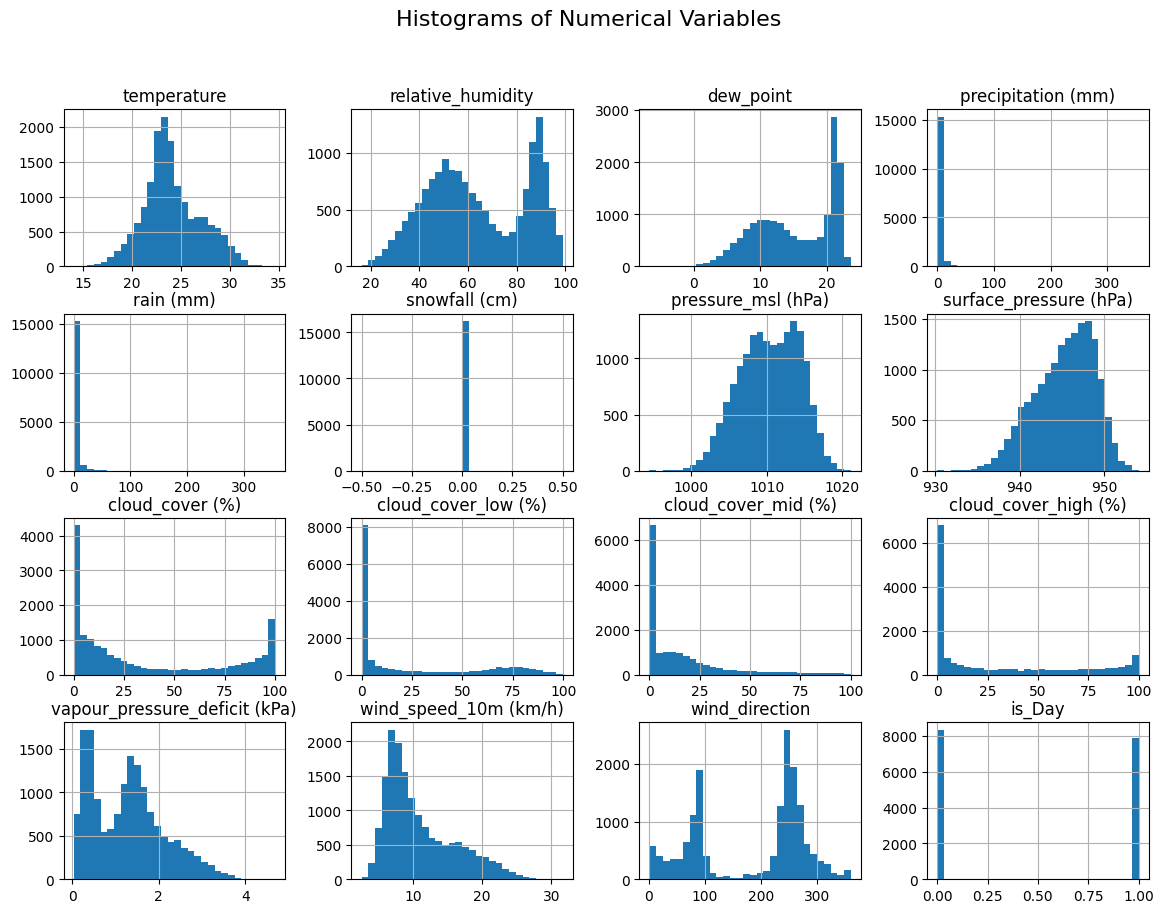

In [3]:

# Histogram of numerical features
data.hist(figsize=(14, 10), bins=30)
plt.suptitle("Histograms of Numerical Variables", fontsize=16)
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



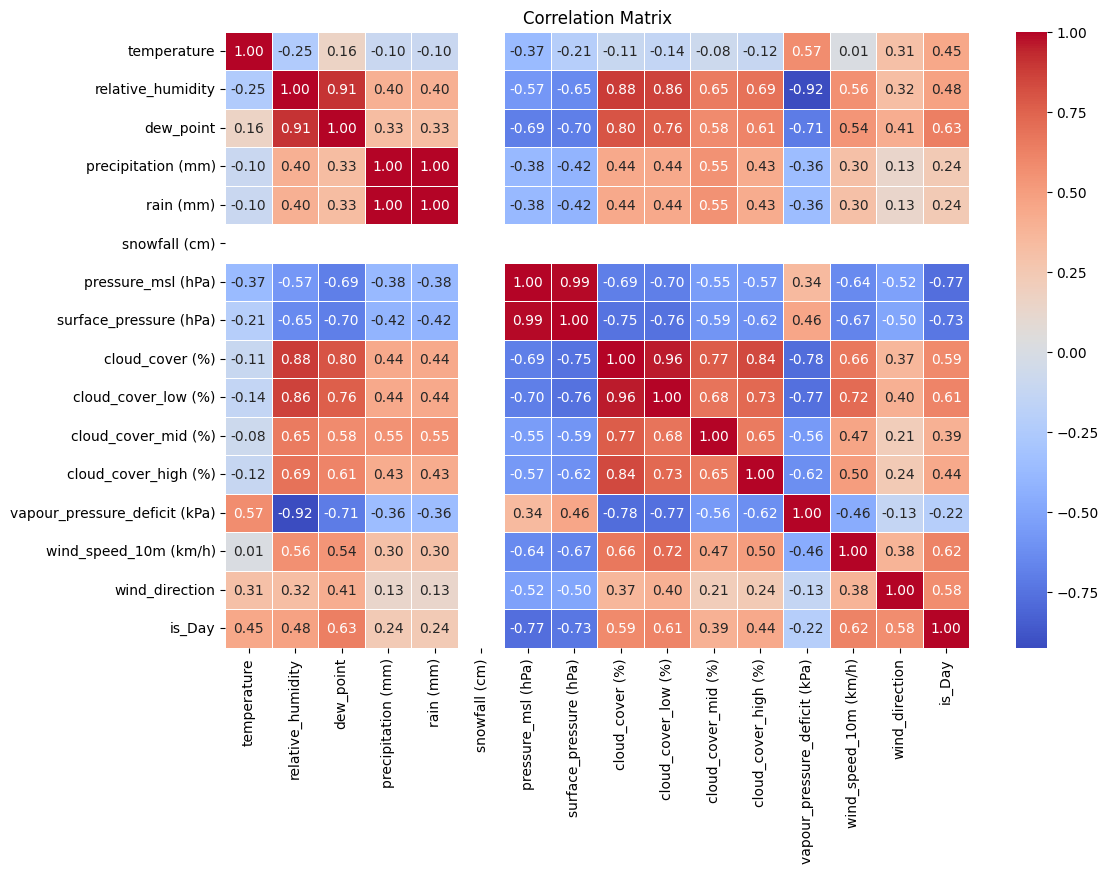

In [4]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


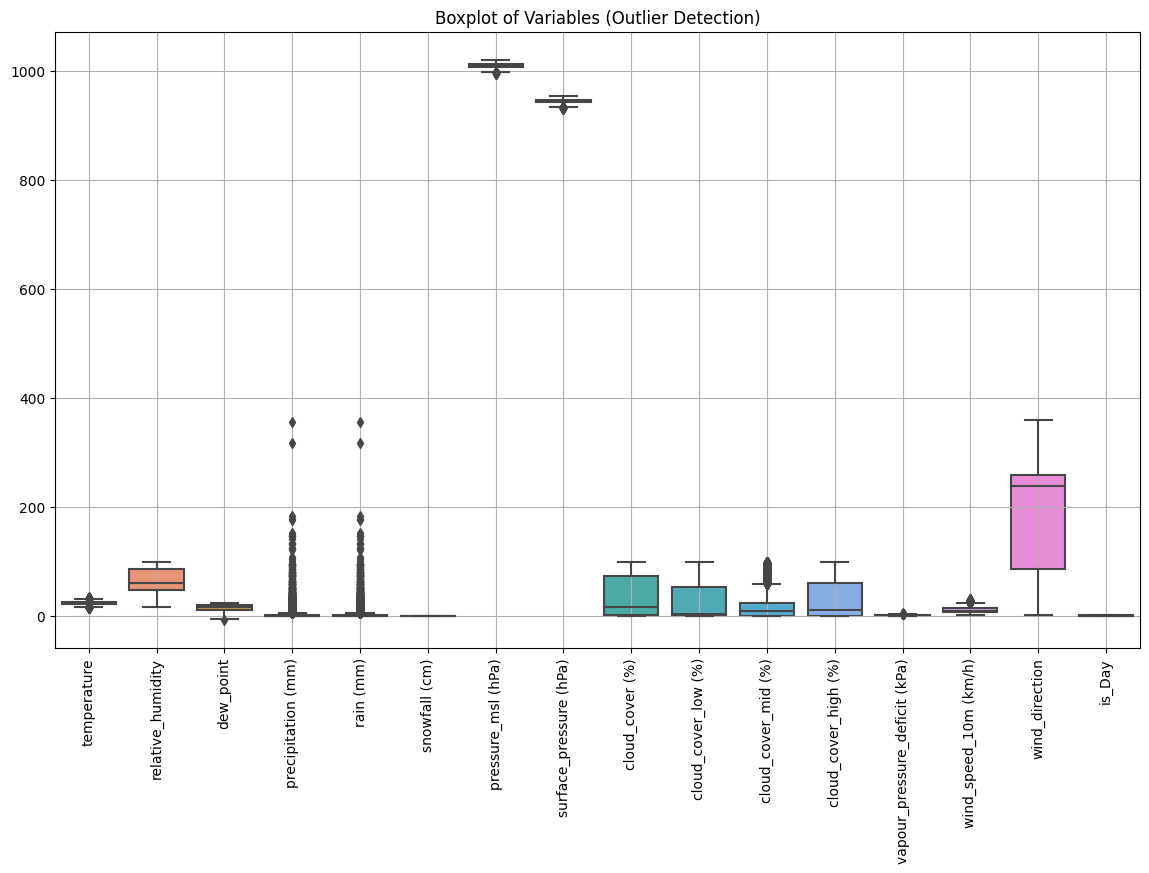

In [5]:

# Boxplots to check for outliers
plt.figure(figsize=(14, 8))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.title("Boxplot of Variables (Outlier Detection)")
plt.grid()
plt.show()

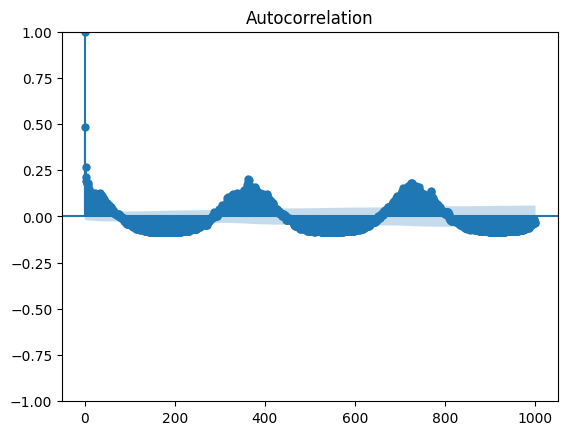

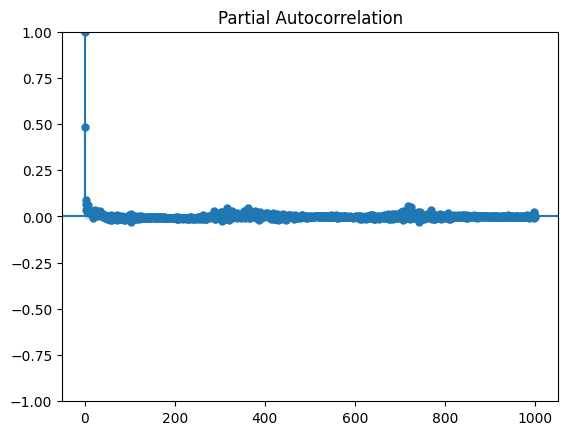

In [6]:
# plt.title('rain acf')
# Plot ACF and PACF to check autocorrelations
plot_acf(data['rain (mm)'], lags=1000)
plt.show()

plot_pacf(data['rain (mm)'], lags=1000)
plt.show()

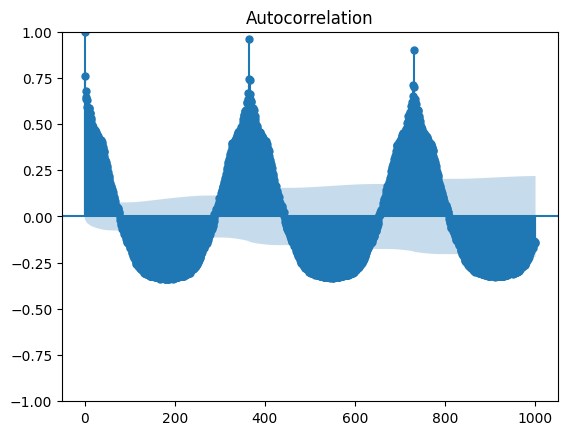

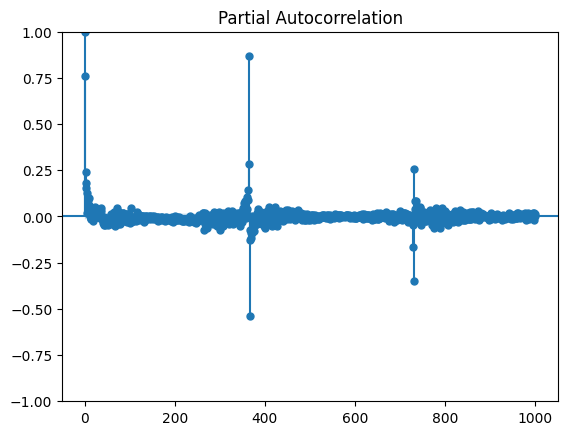

In [7]:
# plt.title('seasonal acf and pacf plots')

### ------------------- STL Decomposition on Full Data ------------------- ###
stl = STL(data['rain (mm)'], seasonal=13, period=365)  # Assuming yearly seasonality
result = stl.fit()

trend, seasonal, remainder = result.trend, result.seasonal, result.resid

# Create DataFrame for STL components
components = pd.DataFrame({'trend': trend, 'seasonal': seasonal, 'remainder': remainder}, index=data.index)


# Plot ACF and PACF to check autocorrelations
plot_acf(seasonal, lags=1000)
plt.show()

plot_pacf(seasonal, lags=1000)
plt.show()

In [8]:
data.columns

Index(['temperature', 'relative_humidity', 'dew_point', 'precipitation (mm)',
       'rain (mm)', 'snowfall (cm)', 'pressure_msl (hPa)',
       'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)',
       'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)',
       'wind_direction', 'is_Day'],
      dtype='object')

In [9]:

# Create a plotly figure for actual vs predicted trend
fig_rain = go.Figure()

# Add actual trend trace
fig_rain.add_trace(go.Scatter(
    x=data.index,  # Skip the first 3 indices to align with predictions
    y=data['rain (mm)'],
    mode='lines',
    name='Actual Rain',
    line=dict(color='blue')
))
fig_rain.update_layout(
    title='Actual Rain (MM)',
    xaxis_title='Date',
    yaxis_title='Rain Values',
    legend=dict(x=0.02, y=0.98),  # Position legend at top-left
    template='plotly_white'
)

# Show the trend plot
fig_rain.show(renderer='iframe')


In [10]:

# Create a plotly figure for actual vs predicted trend
fig_temp = go.Figure()

# Add actual trend trace
fig_temp.add_trace(go.Scatter(
    x=data.index,  # Skip the first 3 indices to align with predictions
    y=data['temperature'],
    mode='lines',
    name='Temperature (C)',
    line=dict(color='blue')
))
fig_temp.update_layout(
    title='Temperature',
    xaxis_title='Date',
    yaxis_title='Temperature (celsius)',
    legend=dict(x=0.02, y=0.98),  # Position legend at top-left
    template='plotly_white'
)

# Show the trend plot
fig_temp.show(renderer='iframe')


In [11]:

# Create a plotly figure for actual precpitation
fig_precp = go.Figure()

# Add actual trend trace
fig_precp.add_trace(go.Scatter(
    x=data.index, 
    y=data['precipitation (mm)'],
    mode='lines',
    name='Precipitation (mm)',
    line=dict(color='blue')
))
fig_precp.update_layout(
    title='Precipitation',
    xaxis_title='Date',
    yaxis_title='Precipitation (mm)',
    legend=dict(x=0.02, y=0.98),  # Position legend at top-left
    template='plotly_white'
)

# Show the trend plot
fig_precp.show(renderer='iframe')


In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 3 rows, 1 column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    subplot_titles=['Actual Rain (MM)', 'Temperature (C)', 'Precipitation (MM)'])

# Add actual rain trace
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['rain (mm)'],
    mode='lines',
    name='Actual Rain',
    line=dict(color='blue')
), row=1, col=1)

# Add temperature trace
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['temperature'],
    mode='lines',
    name='Temperature (C)',
    line=dict(color='red')
), row=2, col=1)

# Add precipitation trace
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['precipitation (mm)'],
    mode='lines',
    name='Precipitation (MM)',
    line=dict(color='green')
), row=3, col=1)

# Update layout
fig.update_layout(
    height=800, width=1000,  # Adjust size
    title_text="Weather Data Over Time",
    xaxis3_title="Date",  # Ensure the x-axis label appears under the last subplot
    template='plotly_white'
)

# Show the figure
fig.show(renderer='iframe')


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 3 rows, 1 column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    subplot_titles=['Wind Speed (km/h)', 'Cloud Cover (%)', 'Surface Pressure (hPa)'])

# Add wind direction trace
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['wind_speed_10m (km/h)'],
    mode='lines',
    name='Wind speed 10m (km/h)',
    line=dict(color='blue')
), row=1, col=1)

# Add cloud cover trace
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['cloud_cover (%)'],
    mode='lines',
    name='Cloud Cover (%)',
    line=dict(color='red')
), row=2, col=1)

# Add surface pressure trace
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['surface_pressure (hPa)'],
    mode='lines',
    name='Surface Pressure (hPa)',
    line=dict(color='green')
), row=3, col=1)

# Update layout
fig.update_layout(
    height=800, width=1000,  # Adjust size
    title_text="Other Weather Data Over Time",
    xaxis3_title="Date",  # Ensure the x-axis label appears under the last subplot
    template='plotly_white'
)

# Show the figure
fig.show(renderer='iframe')


In [14]:

### ------------------- STL Decomposition on Full Data ------------------- ###
stl = STL(data['rain (mm)'], seasonal=13, period=365)  # Assuming yearly seasonality
result = stl.fit()

trend, seasonal, remainder = result.trend, result.seasonal, result.resid

# Create DataFrame for STL components
components = pd.DataFrame({'trend': trend, 'seasonal': seasonal, 'remainder': remainder}, index=data.index)



In [15]:
# Plot STL Decomposition
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=("Original Data", "Trend", "Seasonal", "Remainder"))

fig.add_trace(go.Scatter(x=data.index, y=data['rain (mm)'], mode='lines', name='Original Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=components.index, y=components['trend'], mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=components.index, y=components['seasonal'], mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=components.index, y=components['remainder'], mode='lines', name='Remainder'), row=4, col=1)

fig.update_layout(height=800, width=1000, title_text="STL Decomposition (Rain Data)", showlegend=True)
# fig.show()
fig.show(renderer='iframe')

In [16]:
### ------------------- Train-Test Split (3 years reserved for testing) ------------------- ###
test_years = 3  # Reserve last 3 years (~1095 days) for testing
train_indices = data.index[:-1095]  
test_indices = data.index[-1095:]

# Split STL components
train_trend, test_trend = trend.loc[train_indices], trend.loc[test_indices]
train_seasonal, test_seasonal = seasonal.loc[train_indices], seasonal.loc[test_indices]
train_remainder, test_remainder = remainder.loc[train_indices], remainder.loc[test_indices]


In [17]:
len(test_trend)

1095

In [18]:

### ------------------- Prepare Trend Data (Using nT = 3 time steps) ------------------- ###

def create_sequences(series, n_steps=3):
    """Convert time series data into sequences of n_steps for GRU input"""
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])  # Take n_steps values
        y.append(series[i+n_steps])  # Predict the next value
    return np.array(X), np.array(y)

# Generate input sequences for GRU
X_trend, y_trend = create_sequences(train_trend.values, n_steps=3)
X_test_trend, y_test_trend = create_sequences(test_trend.values, n_steps=3)

# Reshape for GRU input (samples, timesteps, features)
X_trend = X_trend.reshape(X_trend.shape[0], X_trend.shape[1], 1)
X_test_trend = X_test_trend.reshape(X_test_trend.shape[0], X_test_trend.shape[1], 1)


Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.7805 - val_loss: 0.1839
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3084 - val_loss: 0.0911
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1701 - val_loss: 0.0054
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0448 - val_loss: 7.0002e-04
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - val_loss: 2.0130e-04
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 1.3913e-04
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 1.3954e-04
Epoch 8/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 6.7401e-05
Epoch 9/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7518e-04 - val_loss: 8.3340e-05
Epoch 10/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7524e-04 - val_loss: 8.3051e-05
Epoch 11/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3074e-04 - val_loss: 1.1538e-04
Epoch 12/40
119/119

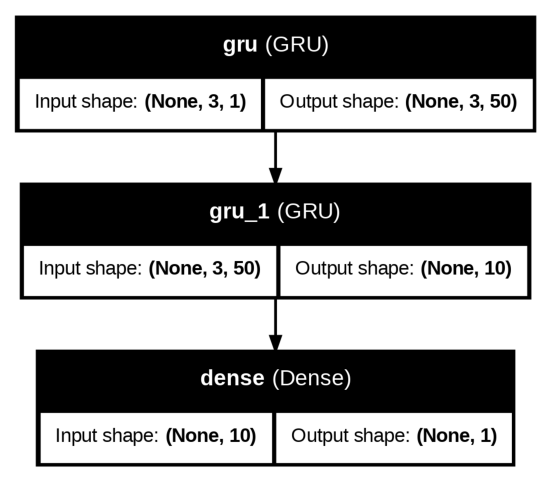

In [19]:
### ------------------- GRU Model for Trend Learning ------------------- ###


# Define model with 2 GRU layers and learning rate of 0.001
model_trend = Sequential([
    GRU(50, input_shape=(3, 1), return_sequences=True),  # First GRU layer with return_sequences=True to pass sequences to the next GRU layer
    GRU(10),  # Second GRU layer
    Dense(1)  # Output layer
])


# Compile model with Adam optimizer and learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model_trend.compile(optimizer=optimizer, loss='mse')

history_trend = model_trend.fit(X_trend, y_trend, epochs=40, batch_size=128, validation_data=(X_test_trend, y_test_trend))
y_pred_trend = model_trend.predict(X_test_trend)


# Save the model visualization
plot_model(model_trend, to_file='gru_model.png', show_shapes=True, show_layer_names=True)

# Display the model architecture
img = plt.imread('gru_model.png')
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [20]:


### -------------------------------------------- Plot Predicted vs Actual Trend ------------------- #########

# Create a plotly figure for actual vs predicted trend
fig_trend = go.Figure()

# Add actual trend trace
fig_trend.add_trace(go.Scatter(
    x=test_indices[3:],  # Skip the first 3 indices to align with predictions
    y=y_test_trend.flatten(),
    mode='lines',
    name='Actual Trend',
    line=dict(color='blue')
))

# Add predicted trend trace
fig_trend.add_trace(go.Scatter(
    x=test_indices[3:],
    y=y_pred_trend.flatten(),
    mode='lines',
    name='Predicted Trend',
    line=dict(color='orange', dash='dash')
))

# Update layout for the trend plot
fig_trend.update_layout(
    title='Actual vs Predicted Trend (GRU with nT=3)',
    xaxis_title='Date',
    yaxis_title='Trend Values',
    legend=dict(x=0.02, y=0.98),  # Position legend at top-left
    template='plotly_white'
)

# Show the trend plot
fig_trend.show(renderer='iframe')


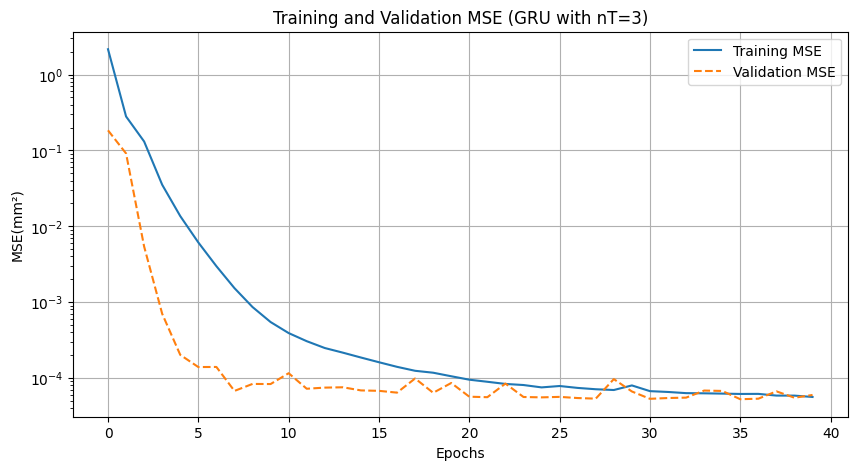

In [21]:
# Extract training and validation MSE from history object
train_mse = history_trend.history['loss']
val_mse = history_trend.history['val_loss']

# Plot MSE (training and validation)
plt.figure(figsize=(10, 5))
plt.plot(train_mse, label="Training MSE")
plt.plot(val_mse, label="Validation MSE", linestyle="dashed")
plt.legend()
plt.grid()
plt.title("Training and Validation MSE (GRU with nT=3)")
plt.xlabel("Epochs")
plt.ylabel("MSE(mm²)")
plt.yscale('log')  # Optional: Log scale to view smaller MSE values more clearly
plt.show()


In [22]:

# Calculate R² score
r2 = r2_score(y_test_trend, y_pred_trend)
rmse = np.sqrt(mean_squared_error(y_test_trend, y_pred_trend))
mae = mean_absolute_error(y_test_trend, y_pred_trend)
# Print R² score
print(f"R²: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



R²: 0.9997933361991879
RMSE: 0.007720489555612326
MAE: 0.006072924671146126


In [23]:

### ------------------- Train-Test Split (3 years reserved for testing) ------------------- ###
test_years = 3  # Reserve last 3 years (~1095 days) for testing
train_indices = data.index[:-1095]  
test_indices = data.index[-1095:]

# Split STL components
train_trend, test_trend = trend.loc[train_indices], trend.loc[test_indices]
train_seasonal, test_seasonal = seasonal.loc[train_indices], seasonal.loc[test_indices]
train_remainder, test_remainder = remainder.loc[train_indices], remainder.loc[test_indices]

# Normalize seasonal components for stable training
scaler = MinMaxScaler()
train_seasonal_scaled = scaler.fit_transform(train_seasonal.values.reshape(-1, 1))
test_seasonal_scaled = scaler.transform(test_seasonal.values.reshape(-1, 1))


In [24]:
# X_train_seasonal.shape

In [25]:
# X_test_seasonal.shape

In [26]:
### ------------------- Create Sequences for Seasonal Model ------------------- ###

# Combine scaled train and test seasonal data for sequence generation
full_seasonal_scaled = np.concatenate([train_seasonal_scaled, test_seasonal_scaled])

# Create sequences with both short-term and long-term patterns
X_seasonal = []
y_seasonal = []
for t in range(1095, len(full_seasonal_scaled)):
    # Recent 4 days (t-1 to t-4)
    recent = [
        full_seasonal_scaled[t-1],
        full_seasonal_scaled[t-2],
        full_seasonal_scaled[t-3],
        full_seasonal_scaled[t-4]
    ]
    # Same days from previous 3 years (t-365, t-730, t-1095)
    seasonal_lags = [
        full_seasonal_scaled[t-365],
        full_seasonal_scaled[t-730],
        full_seasonal_scaled[t-1095]
    ]
    X_seasonal.append(recent + seasonal_lags)
    y_seasonal.append(full_seasonal_scaled[t])

# Convert to numpy arrays and reshape for GRU input
X_seasonal = np.array(X_seasonal).reshape(-1, 7, 1)  # 7 time steps (4+3)
y_seasonal = np.array(y_seasonal)

# Split into train/test sets (last 3 years for testing)
test_size = 1095  # 3 years
X_train_seasonal, X_test_seasonal = X_seasonal[:-test_size], X_seasonal[-test_size:]
y_train_seasonal, y_test_seasonal = y_seasonal[:-test_size], y_seasonal[-test_size:]


In [27]:
# X_train_seasonal.shape

In [28]:
# X_test_seasonal.shape

In [29]:

### ------------------- GRU Model Architecture ------------------- ###
model_GRU = Sequential([
    GRU(128, input_shape=(7, 1), return_sequences=True),
    Dropout(0.3),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1)
])

model_GRU.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

### ------------------- Training with Early Stopping ------------------- ###
history_GRU = model_GRU.fit(
    X_train_seasonal, y_train_seasonal,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_seasonal, y_test_seasonal),
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

### ------------------- Prediction and Evaluation ------------------- ###
y_pred_scaled = model_GRU.predict(X_test_seasonal)

# Inverse scaling transformation
y_pred_seasonal = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test_seasonal.reshape(-1, 1))

# Calculate evaluation metrics
rmse_GRU = np.sqrt(mean_squared_error(y_test_actual, y_pred_seasonal))
mae_GRU = mean_absolute_error(y_test_actual, y_pred_seasonal)
r2_GRU = r2_score(y_test_actual, y_pred_seasonal)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0036 - val_loss: 7.0018e-04
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.2450e-04 - val_loss: 2.8954e-04
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.6757e-04 - val_loss: 4.5810e-04
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.0996e-04 - val_loss: 2.7696e-04
Epoch 5/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.0947e-04 - val_loss: 2.8980e-04
Epoch 6/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.0389e-04 - val_loss: 6.6344e-04
Epoch 7/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.4908e-04 - val_loss: 3.7801e-04
Epoch 8/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.7066e-04 - val_loss: 2.9831e-04
Epoch 9/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.0383e-04 - val_loss: 2.1715e-04
Epoch 10/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.8898e-04 - val_loss: 2.5262e-04
Epoch 11/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 

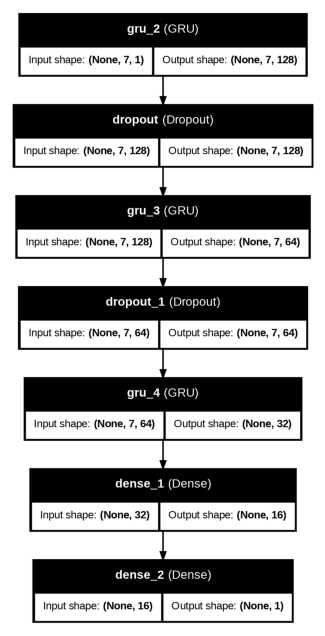

In [30]:
# Save model architecture to a file
plot_model(model_GRU, to_file="gru_model.png", show_shapes=True, show_layer_names=True)

# Display the saved model architecture image
img = Image.open("gru_model.png")
plt.figure(figsize=(14, 8))
plt.imshow(img)
plt.axis("off")
plt.show()


In [31]:
print(f"Performance Metrics:")
print(f"R²: {r2_GRU:.4f}")
print(f"RMSE: {rmse_GRU:.4f} mm")
print(f"MAE: {mae_GRU:.4f} mm")



Performance Metrics:
R²: 0.9853
RMSE: 0.6036 mm
MAE: 0.2895 mm


In [32]:

### ------------------- Plot Training and Validation Loss ------------------- ###

# Extract training and validation loss from the history object
train_loss = history_GRU.history['loss']
val_loss = history_GRU.history['val_loss']

# Create a range for the x-axis (epochs)
epochs = range(1, len(train_loss) + 1)

# Create a Plotly figure for training and validation loss
fig_loss = go.Figure()

# Add training loss trace
fig_loss.add_trace(go.Scatter(
    x=list(epochs),
    y=train_loss,
    mode='lines+markers',
    name='Training Loss',
    line=dict(color='blue')
))

# Add validation loss trace
fig_loss.add_trace(go.Scatter(
    x=list(epochs),
    y=val_loss,
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='orange')
))

# Highlight the best epoch (minimum validation loss)
best_epoch = np.argmin(val_loss) + 1
fig_loss.add_vline(
    x=best_epoch,
    line=dict(color='red', dash='dash'),
    annotation_text=f'Best Epoch: {best_epoch}',
    annotation_position='top right'
)

# Update layout for the loss plot
fig_loss.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis_title='Epochs',
    yaxis_title='Loss (MSE mm²)',
    legend=dict(x=0.02, y=0.98),
    template='plotly_white'
)

# Show the loss plot
fig_loss.show(renderer='iframe')


In [33]:

### ------------------- Plot Actual vs Predicted Values ------------------- ###

# Create a Plotly figure for actual vs predicted values
fig_predictions = go.Figure()

# Add actual values trace
fig_predictions.add_trace(go.Scatter(
    x=test_indices,
    y=y_test_actual.flatten(),
    mode='lines',
    name='Actual Values',
    line=dict(color='blue')
))

# Add predicted values trace
fig_predictions.add_trace(go.Scatter(
    x=test_indices,
    y=y_pred_seasonal.flatten(),
    mode='lines',
    name='Predicted Values',
    line=dict(color='orange', dash='dash')
))

# Update layout for the predictions plot
fig_predictions.update_layout(
    title='Seasonal Component: Actual vs Predicted Values',
    xaxis_title='Date',
    yaxis_title='Seasonal Values',
    legend=dict(x=0.02, y=0.98),
    template='plotly_white'
)

# Show the predictions plot
fig_predictions.show(renderer='iframe')


In [34]:

### ------------------- Scatter Plot for Predictions Accuracy ------------------- ###

# Create a Plotly figure for the scatter plot
fig_scatter = go.Figure()

# Add scatter plot trace
fig_scatter.add_trace(go.Scatter(
    x=y_test_actual.flatten(),
    y=y_pred_seasonal.flatten(),
    mode='markers',
    marker=dict(color='rgba(0, 0, 255, 0.6)'),
    name='Predictions'
))

# Add a diagonal line for perfect predictions
fig_scatter.add_trace(go.Scatter(
    x=[y_test_actual.min(), y_test_actual.max()],
    y=[y_test_actual.min(), y_test_actual.max()],
    mode='lines',
    line=dict(color='black', dash='dash'),
    name='Perfect Prediction'
))

# Update layout for the scatter plot
fig_scatter.update_layout(
    title='Seasonal Predictions Accuracy',
    xaxis_title='Actual Seasonal Values',
    yaxis_title='Predicted Seasonal Values',
    showlegend=True,
    template='plotly_white'
)

# Show the scatter plot
fig_scatter.show(renderer='iframe')

Selected Meteorological Variables:
['temperature', 'relative_humidity', 'precipitation (mm)', 'pressure_msl (hPa)', 'cloud_cover (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)', 'wind_speed_10m (km/h)', 'wind_direction', 'is_Day']


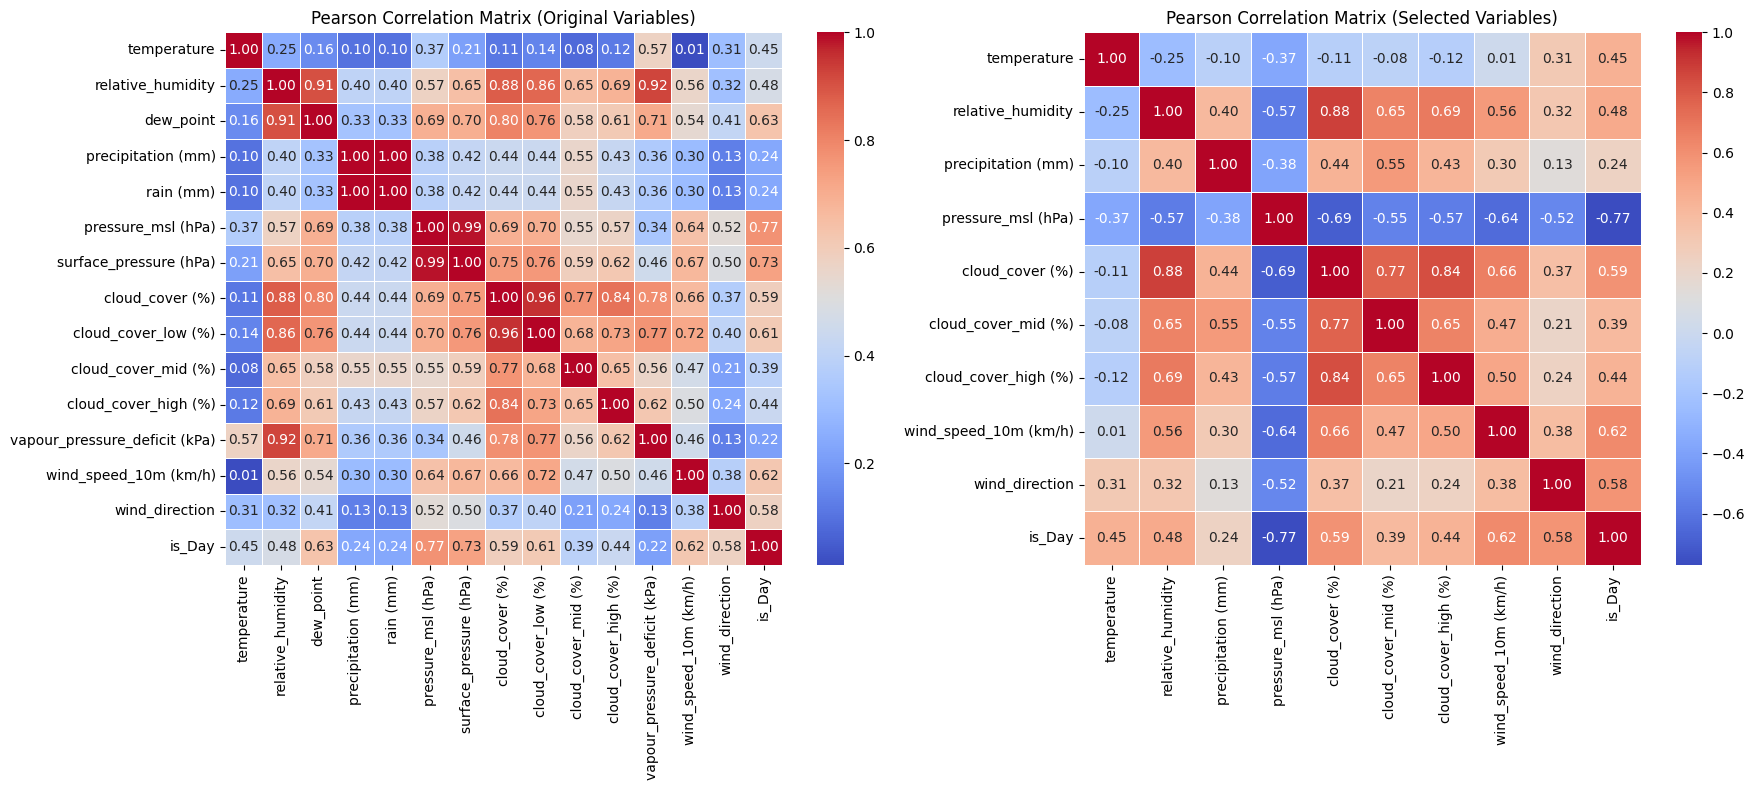

In [35]:

# Load data (assuming it is already preprocessed)
meteorological_vars = [
    'temperature', 'relative_humidity', 'dew_point', 'precipitation (mm)',
    'rain (mm)', 'pressure_msl (hPa)', 'surface_pressure (hPa)',
    'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
    'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)', 'wind_direction', 'is_Day'
]

# Compute Pearson correlation matrix
corr_matrix = data[meteorological_vars].corr().abs()

# Identify highly correlated variables (correlation > 0.9)
high_corr_pairs = np.where(corr_matrix > 0.9)
high_corr_pairs = [(meteorological_vars[i], meteorological_vars[j]) for i, j in zip(*high_corr_pairs) if i != j and i < j]

# Remove redundant variables (keep only one per highly correlated pair)
variables_to_remove = set()
for var1, var2 in high_corr_pairs:
    variables_to_remove.add(var2)  # Remove the second variable in the pair

selected_meteorological_vars = [var for var in meteorological_vars if var not in variables_to_remove]

# Print selected meteorological variables
print("Selected Meteorological Variables:")
print(selected_meteorological_vars)

# Create figure with two subplots for before and after correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot original correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Pearson Correlation Matrix (Original Variables)")

# Plot selected variables correlation matrix
sns.heatmap(data[selected_meteorological_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Pearson Correlation Matrix (Selected Variables)")

plt.tight_layout()
plt.show()


In [36]:


# Define the time differences (lags) from Table 5
lags = [365, 1, 2, 364, 366, 730, 3, 363, 11, 729]

# Create a DataFrame with the remainder component
df = data.copy()
df['remainder'] = components['remainder']

# Generate lagged remainder features
for lag in lags:
    df[f'remainder_lag_{lag}'] = df['remainder'].shift(lag)

# Select meteorological variables based on correlation analysis
meteorological_vars = [
    'temperature', 'relative_humidity', 'dew_point', 'precipitation (mm)',
    'rain (mm)', 'pressure_msl (hPa)', 'surface_pressure (hPa)',
    'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
    'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)', 'wind_direction', 'is_Day'
]

# Compute Pearson correlation matrix
corr_matrix = data[meteorological_vars].corr().abs()

# Identify highly correlated variables (correlation > 0.9)
high_corr_pairs = np.where(corr_matrix > 0.7)
high_corr_pairs = [(meteorological_vars[i], meteorological_vars[j]) for i, j in zip(*high_corr_pairs) if i != j and i < j]

# Remove redundant variables (keep only one per highly correlated pair)
variables_to_remove = set()
for var1, var2 in high_corr_pairs:
    variables_to_remove.add(var2)  # Remove the second variable in the pair

selected_meteorological_vars = [var for var in meteorological_vars if var not in variables_to_remove]

# Print selected meteorological variables
print("Selected Meteorological Variables:")
print(selected_meteorological_vars)

# Add selected meteorological variables to the feature set
feature_columns = [f'remainder_lag_{lag}' for lag in lags] + selected_meteorological_vars
target_column = 'remainder'

# Create dataset and drop missing values
dataset = df[feature_columns + [target_column]].dropna()

# Split data into train and test sets
test_years = 3  # Reserve last 3 years (~1095 days) for testing
test_indices = dataset.index[-1095:]
train_indices = dataset.index[:-1095]

X = dataset[feature_columns]
y = dataset[target_column]
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

# Train LightGBM model with optimal parameters
lgb_model = lgb.LGBMRegressor(
    num_leaves=128,
    min_child_samples=16,
    learning_rate=0.01,
    n_estimators=70,
    random_state=42
)

# Train the model
lgb_model.fit(X_train, y_train)
y_test_remainder=y_test
# Predict on test set
y_pred_remainder = lgb_model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred_remainder)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_remainder))
mae = mean_absolute_error(y_test, y_pred_remainder)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f} mm")
print(f"MAE: {mae:.4f} mm")


Selected Meteorological Variables:
['temperature', 'relative_humidity', 'precipitation (mm)', 'pressure_msl (hPa)', 'wind_direction']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3807
[LightGBM] [Info] Number of data points in the train set: 14404, number of used features: 15
[LightGBM] [Info] Start training from score 0.002990
R²: 0.6790
RMSE: 3.4081 mm
MAE: 1.5664 mm


In [37]:
# 2. Time series plot of actual vs predicted
fig_time_series = go.Figure()
fig_time_series.add_trace(go.Scatter(
    x=y_test.index, y=y_test, mode='lines', name='Actual', line=dict(color='blue')
))
fig_time_series.add_trace(go.Scatter(
    x=y_test.index, y=y_pred_remainder, mode='lines', name='Predicted', line=dict(color='orange', dash='dash')
))
fig_time_series.update_layout(
    title='Remainder Component: Actual vs Predicted',
    xaxis_title='Date',
    yaxis_title='Remainder Value',
    showlegend=True,
    template='plotly_white'
)
fig_time_series.show(renderer='iframe')


In [38]:

# Visualize results using Plotly
# 1. Scatter plot of predicted vs actual
fig_scatter = go.Figure()
fig_scatter.add_trace(go.Scatter(
    x=y_test, y=y_pred_remainder, mode='markers', name='Predicted vs Actual',
    marker=dict(color='blue', opacity=0.5)
))
fig_scatter.add_trace(go.Scatter(
    x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
    mode='lines', name='Perfect Prediction', line=dict(color='red', dash='dash')
))
fig_scatter.update_layout(
    title='Predicted vs Actual Remainder Values',
    xaxis_title='Actual Remainder',
    yaxis_title='Predicted Remainder',
    showlegend=True,
    template='plotly_white'
)
fig_scatter.show(renderer='iframe')



In [39]:

# 3. Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

fig_feature_importance = px.bar(
    feature_importance.head(20), x='Importance', y='Feature', orientation='h',
    title='Top 20 Feature Importances'
)
fig_feature_importance.update_layout(template='plotly_white')
fig_feature_importance.show(renderer='iframe')

In [40]:
print(f"Trend Model R²: {r2_score(y_test_trend, y_pred_trend)}")
print(f"Seasonal Model R²: {r2_score(y_test_actual, y_pred_seasonal)}")
print(f"Remainder Model R²: {r2_score(y_test_remainder, y_pred_remainder)}")





Trend Model R²: 0.9997933361991879
Seasonal Model R²: 0.9852820155826737
Remainder Model R²: 0.6790381138021147


In [41]:
len(y_pred_remainder)

1095

In [42]:
len(y_pred_seasonal)

1095

In [43]:
len(y_pred_trend)

1092

In [52]:
# Combine predictions with non-negative constraint
# predicted_rainfall = np.maximum(0, y_pred_trend + y_pred_seasonal[3:] + y_pred_remainder[3:])
predicted_rainfall = np.maximum(0, y_pred_trend.flatten() + y_pred_seasonal[3:].flatten() + y_pred_remainder[3:])

# print(test_indices[3:].shape)
# print(data['rain (mm)'].loc[test_indices[3:]].shape)
# print(predicted_rainfall.shape)

# Create a DataFrame for the combined predictions
results = pd.DataFrame({
    'Date': test_indices[3:],  # Align dates with predictions
    'Actual Rainfall': data['rain (mm)'].loc[test_indices[3:]],  # Actual rainfall
    'Predicted Rainfall': predicted_rainfall  # Combined predictions
})


# Calculate evaluation metrics for the combined predictions
r2_combined = r2_score(results['Actual Rainfall'], results['Predicted Rainfall'])
rmse_combined = np.sqrt(mean_squared_error(results['Actual Rainfall'], results['Predicted Rainfall']))
mae_combined = mean_absolute_error(results['Actual Rainfall'], results['Predicted Rainfall'])

print(f"Combined Model Performance Metrics:")
print(f"R²: {r2_combined:.4f}")
print(f"RMSE: {rmse_combined:.4f} mm")
print(f"MAE: {mae_combined:.4f} mm")


Combined Model Performance Metrics:
R²: 0.7902
RMSE: 3.3351 mm
MAE: 1.3846 mm


In [53]:
# Plot actual vs predicted rainfall using Plotly
fig_combined = go.Figure()
fig_combined.add_trace(go.Scatter(
    x=results['Date'], y=results['Actual Rainfall'], mode='lines', name='Actual Rainfall',
    line=dict(color='blue')
))
fig_combined.add_trace(go.Scatter(
    x=results['Date'], y=results['Predicted Rainfall'], mode='lines', name='Predicted Rainfall',
    line=dict(color='orange', dash='dash')
))
fig_combined.update_layout(
    title='Actual vs Predicted Rainfall (Last 3 Years)',
    xaxis_title='Date',
    yaxis_title='Rainfall (mm)',
    showlegend=True,
    template='plotly_white'
)
fig_combined.show(renderer='iframe')


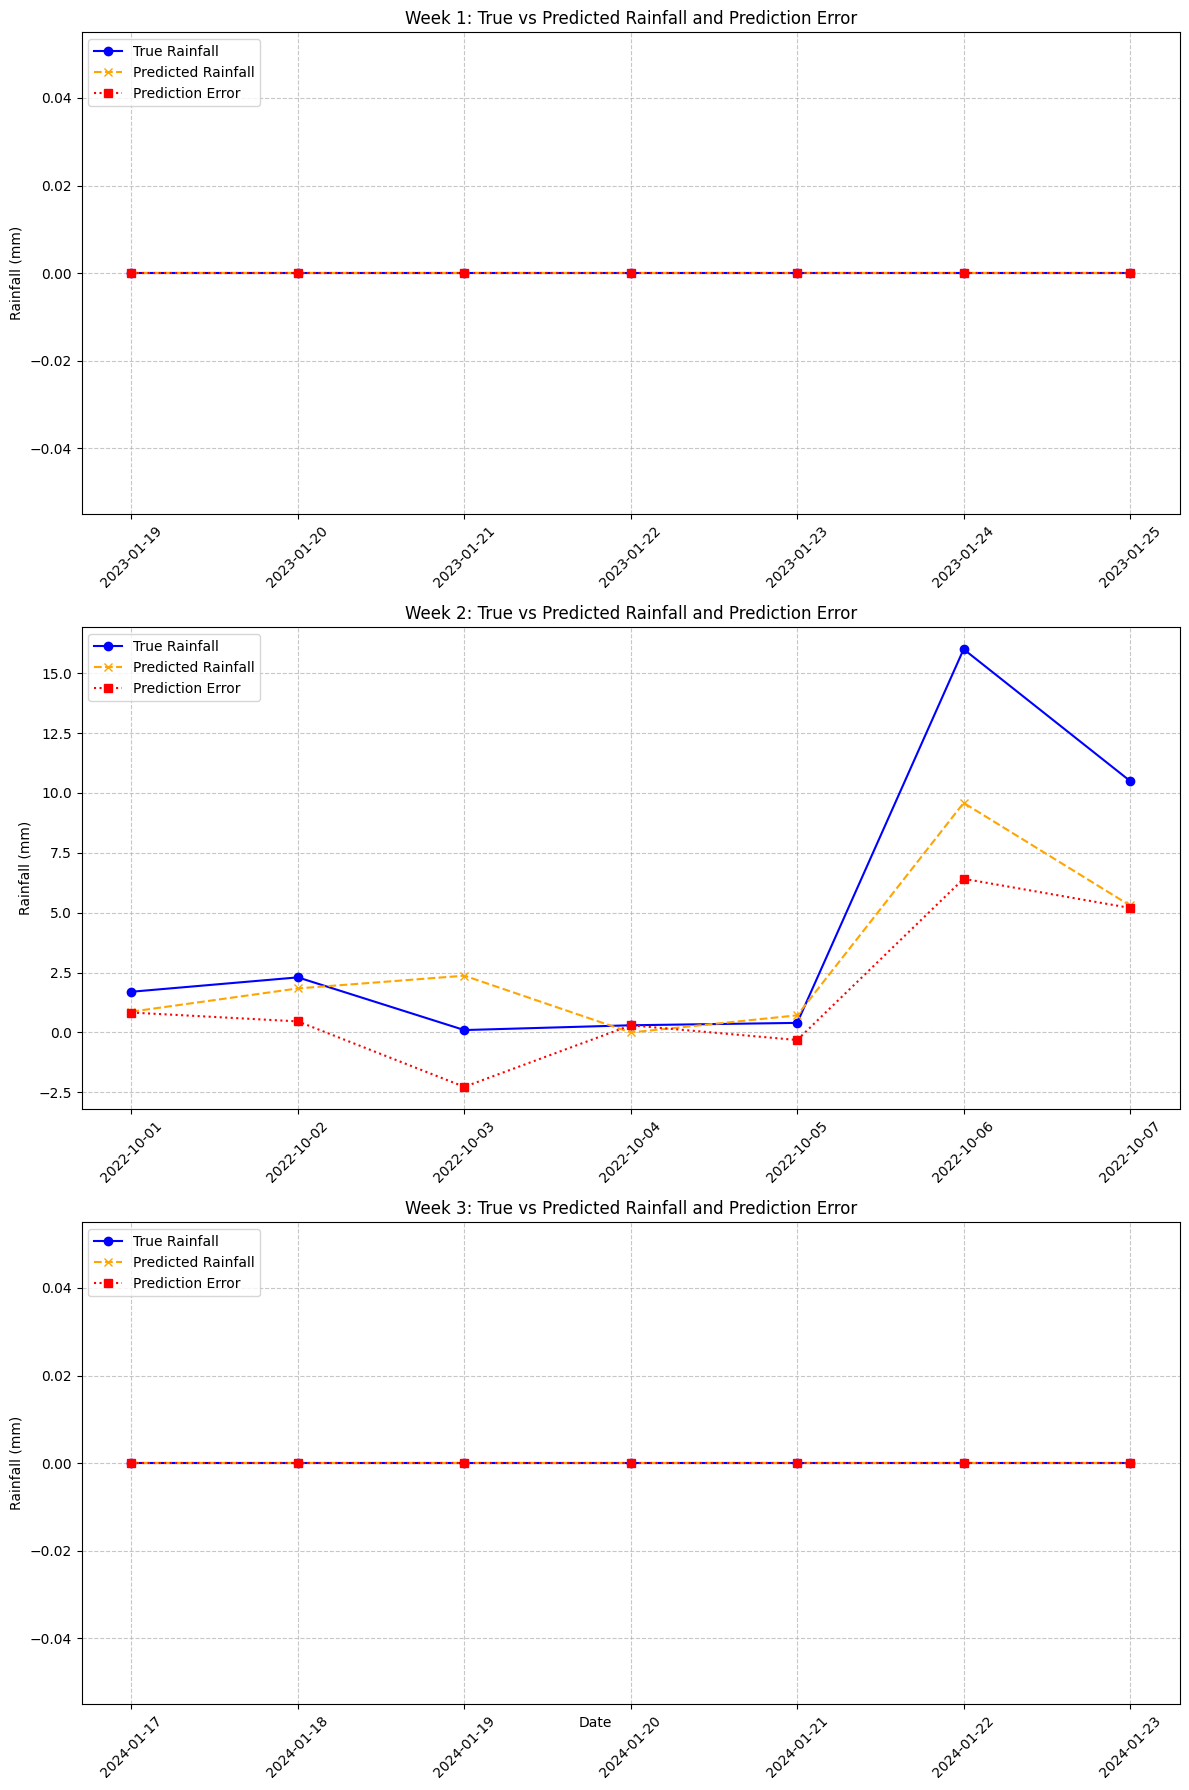

In [57]:

# Assuming you already have the following variables:
# results: DataFrame containing 'Date', 'Actual Rainfall', and 'Predicted Rainfall'
results['Prediction Error'] = results['Actual Rainfall']- results['Predicted Rainfall']

# Function to randomly select 5 weeks
def select_random_weeks(data, num_weeks=5):
    weeks = []
    for _ in range(num_weeks):
        # Randomly select a start index for a week (7 days)
        start_idx = np.random.randint(0, len(data) - 7)
        week = data.iloc[start_idx:start_idx + 7]  # Select 7 days
        weeks.append(week)
    return weeks

# Select 5 random weeks
random_weeks = select_random_weeks(results, num_weeks=3)

# Create a figure with 5 rows and 1 column for each week
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=False)

# Function to plot a single week
def plot_week(ax, week, title):
    # Plot True Rainfall
    ax.plot(week['Date'], week['Actual Rainfall'], label='True Rainfall', color='blue', marker='o')
    # Plot Predicted Rainfall
    ax.plot(week['Date'], week['Predicted Rainfall'], label='Predicted Rainfall', color='orange', linestyle='--', marker='x')
    # Plot Prediction Error
    ax.plot(week['Date'], week['Prediction Error'], label='Prediction Error', color='red', linestyle=':', marker='s')
    
    # Add titles and labels
    ax.set_title(title)
    ax.set_ylabel("Rainfall (mm)")
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45)

# Plot each week
for i, week in enumerate(random_weeks):
    plot_week(axes[i], week, f"Week {i+1}: True vs Predicted Rainfall and Prediction Error")

# Add a common x-label
fig.text(0.5, 0.04, 'Date', ha='center', va='center')

# Adjust layout
plt.tight_layout()
plt.show()

In [47]:
import pandas as pd

# Define the results for each model
results = {
    'Model': ['Trend', 'Seasonal', 'Remainder', 'Combined'],
    'R²': [0.9998, 0.9752,  0.6790,0.7998],
    'RMSE (mm)': [0.0070,3.4081, 2.0034, 3.3387 ],
    'MAE (mm)': [0.0054, 0.4465,  1.5664, 1.3643]
}






# Create the DataFrame
results_df = pd.DataFrame(results)

# Set the Model column as the index
results_df.set_index('Model', inplace=True)

# Display the DataFrame
results_df

,R²,RMSE (mm),MAE (mm)
Model,,,
Trend,0.9998,0.0070,0.0054
Seasonal,0.9752,3.4081,0.4465
Remainder,0.6790,2.0034,1.5664
Combined,0.7898,3.3387,1.3643


In [48]:
# Create sequences for GRU input
def create_sequences(series, n_steps=7):
    """Convert time series data into sequences of n_steps for GRU input."""
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])  # Take n_steps values
        y.append(series[i+n_steps])  # Predict the next value
    return np.array(X), np.array(y)

# Prepare data for GRU
n_steps = 7  # Use 7 days as input sequence
X, y = create_sequences(data['rain (mm)'].values, n_steps=n_steps)

# Reshape for GRU input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split (last 3 years for testing)
test_size = 1095  # 3 years
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Define the GRU model
model = Sequential([
    GRU(50, input_shape=(n_steps, 1), return_sequences=True),  # First GRU layer
    GRU(25),  # Second GRU layer
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict on the test set
y_pred = model.predict(X_test).flatten()

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



473/473 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 74.6072 - val_loss: 37.6157
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 62.1296 - val_loss: 36.6244
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 70.7386 - val_loss: 36.5020
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 59.7605 - val_loss: 35.9128
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 56.0721 - val_loss: 36.2386
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 47.1957 - val_loss: 36.2829
Epoch 7/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 67.2984 - val_loss: 36.7477
Epoch 8/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 67.1425 - val_loss: 36.5226
Epoch 9/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 52.3356 - val_loss: 37.9161
Epoch 10/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 63.8095 - val_loss: 37.0975
Epoch 11/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 52.5365 - val_loss: 37.0904
Epoch 12/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 

In [49]:

print(f"Baseline GRU Model Performance Metrics:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f} mm")
print(f"MAE: {mae:.4f} mm")


Baseline GRU Model Performance Metrics:
R²: 0.1618
RMSE: 6.6703 mm
MAE: 2.2121 mm


In [ ]:

# Plot actual vs predicted rainfall
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data.index[-test_size + n_steps:], y=y_test, mode='lines', name='Actual Rainfall', line=dict(color='blue')))
fig.add_trace(go.Scatter(
    x=data.index[-test_size + n_steps:], y=y_pred, mode='lines', name='Predicted Rainfall', line=dict(color='orange', dash='dash')))
fig.update_layout(
    title='Baseline GRU Model: Actual vs Predicted Rainfall',
    xaxis_title='Date',
    yaxis_title='Rainfall (mm)',
    showlegend=True,
    template='plotly_white'
)
fig.show(renderer='iframe')



In [ ]:
# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(
    x=list(range(1, len(train_loss) + 1)), y=train_loss, mode='lines', name='Training Loss', line=dict(color='blue')))
fig_loss.add_trace(go.Scatter(
    x=list(range(1, len(val_loss) + 1)), y=val_loss, mode='lines', name='Validation Loss', line=dict(color='orange')))
fig_loss.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss (MSE)',
    showlegend=True,
    template='plotly_white'
)
fig_loss.show(renderer='iframe')